# Green Space Detection Pipeline

Multi-temporal analysis using Sentinel-2 satellite imagery and Random Forest classification.

## 1. Generate AOIs for 15 Cities

Create 512×512 pixel (5.12 km) square areas of interest centered on each city.

In [ ]:
#tim
import json
import os
import shapely.geometry
from shapely.ops import transform
import pyproj

In [2]:
# City coordinates (longitude, latitude)
cities = {
    "Vienna": (16.3738, 48.2082), "Paris": (2.3522, 48.8566),
    "London": (-0.1276, 51.5074), "Toronto": (-79.3832, 43.6532),
    "Vancouver": (-123.1207, 49.2827), "San_Francisco": (-122.4194, 37.7749),
    "Lisbon": (-9.1393, 38.7223), "Madrid": (-3.7038, 40.4168),
    "Barcelona": (2.1734, 41.3851), "Berlin": (13.4050, 52.5200),
    "Amsterdam": (4.9041, 52.3676), "Melbourne": (144.9631, -37.8136),
    "Sydney": (151.2093, -33.8688), "Auckland": (174.7633, -36.8485),
    "Seattle": (-122.3321, 47.6062)
}

AOI_SIZE_M = 512 * 10  # 5.12 km square
OUTPUT_FOLDER = "aois_json"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [3]:
def create_square_aoi(center_lon, center_lat, size_m):
    """Create square AOI using UTM projection."""
    utm_zone = int((center_lon + 180) / 6) + 1
    utm = pyproj.Proj(proj='utm', zone=utm_zone, ellps='WGS84')
    wgs84 = pyproj.Proj(proj='latlong', datum='WGS84')

    project_to_utm = pyproj.Transformer.from_proj(wgs84, utm, always_xy=True).transform
    project_to_wgs = pyproj.Transformer.from_proj(utm, wgs84, always_xy=True).transform

    point = shapely.geometry.Point(center_lon, center_lat)
    point_utm = transform(project_to_utm, point)

    half_size = size_m / 2
    square_utm = shapely.geometry.box(
        point_utm.x - half_size, point_utm.y - half_size,
        point_utm.x + half_size, point_utm.y + half_size
    )

    return transform(project_to_wgs, square_utm)

# Generate GeoJSON for each city
for city, (lon, lat) in cities.items():
    square = create_square_aoi(lon, lat, AOI_SIZE_M)
    geojson = {
        "type": "FeatureCollection",
        "features": [{
            "type": "Feature",
            "properties": {"city": city},
            "geometry": {"type": "Polygon", "coordinates": [list(square.exterior.coords)]}
        }]
    }
    
    filepath = os.path.join(OUTPUT_FOLDER, f"{city.replace(' ', '_')}.geojson")
    with open(filepath, "w") as f:
        json.dump(geojson, f, indent=2)
    print(f"✓ {city}")

print(f"\n✓ Saved {len(cities)} AOIs to '{OUTPUT_FOLDER}/'")

✓ Vienna
✓ Paris
✓ London
✓ Toronto
✓ Vancouver
✓ San_Francisco
✓ Lisbon
✓ Madrid
✓ Barcelona
✓ Berlin
✓ Amsterdam
✓ Melbourne
✓ Sydney
✓ Auckland
✓ Seattle

✓ Saved 15 AOIs to 'aois_json/'


## 2. Process Sentinel-2 Multi-Temporal Stacks

Load and stack 4 bands (B02, B03, B04, B08) from 3 months (April, August, November).

In [4]:
import rasterio
import numpy as np
from pathlib import Path

In [ ]:
# Configuration
BASE_PATH = "sentinel_data"
CITIES = ["London", "Melbourne", "Paris", "Seattle", "San_Francisco"]

MONTHS = {
    "April": "April-10m",
    "August": "August-10m",
    "November": "November-10m"
}

BANDS = ["B02", "B03", "B04", "B08"]
OUTPUT_FOLDER = "processed_stacks"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [6]:
def find_band_file(folder_path, band_name):
    """Find band file with flexible pattern matching."""
    folder = Path(folder_path)
    if not folder.exists():
        return None
    
    patterns = [f"*_{band_name}_10m.jp2", f"*_{band_name}.jp2", 
                f"**/*_{band_name}_10m.jp2", f"**/IMG_DATA/**/*{band_name}*.jp2"]
    
    for pattern in patterns:
        matches = list(folder.glob(pattern))
        if matches:
            return str(matches[0])
    
    for file in folder.rglob("*.jp2"):
        if band_name in file.name:
            return str(file)
    return None

def load_month_stack(folder_path, bands):
    """Load and stack bands for one month."""
    band_arrays = []
    profile = None
    
    for band in bands:
        band_file = find_band_file(folder_path, band)
        if band_file is None:
            continue
            
        with rasterio.open(band_file) as src:
            band_arrays.append(src.read(1))
            if profile is None:
                profile = src.profile.copy()
    
    if not band_arrays:
        return None, None
    
    return np.stack(band_arrays, axis=0), profile

In [7]:
for city in CITIES:
    print(f"\nProcessing {city}...")
    all_months = []
    final_profile = None
    
    for month_name, month_suffix in MONTHS.items():
        folder = f"{BASE_PATH}/{city}/{city}-{month_suffix}"
        if not os.path.exists(folder):
            print(f"  ⚠ Missing: {month_name}")
            continue
        
        month_data, profile = load_month_stack(folder, BANDS)
        if month_data is not None:
            all_months.append(month_data)
            if final_profile is None:
                final_profile = profile
            print(f"  ✓ {month_name}: {month_data.shape[0]} bands")
    
    if not all_months:
        print(f"  ✗ No data for {city}")
        continue
    
    # Create multi-month stack
    full_stack = np.concatenate(all_months, axis=0).astype(np.uint16)
    final_profile.update(count=full_stack.shape[0], dtype='uint16', compress='lzw')
    
    output_path = f"{OUTPUT_FOLDER}/{city}_MultiMonth_stack.tif"
    with rasterio.open(output_path, 'w', **final_profile) as dst:
        dst.write(full_stack)
    
    print(f"  ✓ Saved: {output_path} ({full_stack.shape[0]} bands)")

print(f"\n✓ Processing complete!")


Processing London...
  ✓ April: 4 bands
  ✓ August: 4 bands
  ✓ November: 4 bands
  ✓ Saved: processed_stacks/London_MultiMonth_stack.tif (12 bands)

Processing Melbourne...
  ✓ April: 4 bands
  ✓ August: 4 bands
  ✓ November: 4 bands
  ✓ Saved: processed_stacks/Melbourne_MultiMonth_stack.tif (12 bands)

Processing Paris...
  ✓ April: 4 bands
  ✓ August: 4 bands
  ✓ November: 4 bands
  ✓ Saved: processed_stacks/Paris_MultiMonth_stack.tif (12 bands)

Processing Seattle...
  ✓ April: 4 bands
  ✓ August: 4 bands
  ✓ November: 4 bands
  ✓ Saved: processed_stacks/Seattle_MultiMonth_stack.tif (12 bands)

Processing Stockholm...
  ⚠ Missing: April
  ⚠ Missing: August
  ⚠ Missing: November
  ✗ No data for Stockholm

✓ Processing complete!


## 3. Fetch OSM Green Space Data

Download ground truth labels from OpenStreetMap (parks, forests, gardens).

In [8]:
import osmnx as ox
import geopandas as gpd

In [ ]:
# OSM green space tags
tags = {
    "leisure": ["park", "garden"],
    "landuse": ["forest", "grass", "meadow", "village_green"],
    "natural": ["wood", "scrub"]
}

cities = ["London", "Melbourne", "Paris", "Seattle", "Stockholm"]

for city in cities:
    aoi_file = f"aois_json/{city}.geojson"
    output_file = f"sentinel_data/{city}/{city}_OSM_green.geojson"
    
    if not os.path.exists(aoi_file):
        print(f"⚠ Missing AOI: {city}")
        continue
    
    try:
        aoi = gpd.read_file(aoi_file).to_crs("EPSG:4326")
        polygon = aoi.geometry.iloc[0]
        
        green_features = ox.features_from_polygon(polygon, tags)
        green_features = green_features[green_features.geometry.type.isin(["Polygon", "MultiPolygon"])]
        
        if len(green_features) == 0:
            print(f"⚠ {city}: No green features found")
            continue
        
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        green_features.to_file(output_file, driver="GeoJSON")
        
        area_km2 = green_features.to_crs('EPSG:3857').area.sum() / 1e6
        print(f"✓ {city}: {len(green_features)} features, {area_km2:.2f} km²")
        
    except Exception as e:
        print(f"✗ {city}: {str(e)}")

print("\n✓ OSM data fetched!")

✓ London: 1346 features, 17.34 km²
✓ Melbourne: 1909 features, 14.89 km²
✓ Paris: 2559 features, 7.99 km²
✓ Seattle: 419 features, 6.62 km²
✓ San_Francisco: 645 features, 12.62 km²

✓ OSM data fetched!


## 4. Rasterize OSM Labels

Convert vector polygons to raster labels matching Sentinel-2 resolution.

In [28]:
from rasterio.features import rasterize

cities = ["London", "Melbourne", "Paris", "Seattle", "San_Francisco"]

for city in cities:
    stack_path = f"processed_stacks/{city}_MultiMonth_stack.tif"
    osm_path = f"sentinel_data/{city}/{city}_OSM_green.geojson"
    label_path = f"sentinel_data/{city}/{city}_OSM_labels.tif"
    
    if not os.path.exists(stack_path) or not os.path.exists(osm_path):
        print(f"⚠ Missing data for {city}")
        continue
    
    try:
        # Load AOI for water feature fetching
        aoi = gpd.read_file(f"aois_json/{city}.geojson").to_crs("EPSG:4326")
        polygon = aoi.geometry.iloc[0]
        
        # Fetch water bodies (rivers, streams, canals, lakes) to exclude
        water_tags = {
            "natural": ["water"],
            "waterway": ["river", "stream", "canal", "riverbank"]
        }
        
        try:
            water_features = ox.features_from_polygon(polygon, water_tags)
            water_features = water_features[water_features.geometry.type.isin(["Polygon", "MultiPolygon"])]
            print(f"  {city}: Found {len(water_features)} water features to exclude")
        except Exception as e:
            print(f"  {city}: No water features found")
            water_features = gpd.GeoDataFrame()
        
        # Load raster metadata
        with rasterio.open(stack_path) as src:
            transform = src.transform
            out_shape = (src.height, src.width)
            crs = src.crs
        
        # Rasterize green spaces
        green_features = gpd.read_file(osm_path).to_crs(crs)
        green_features = green_features[green_features.geometry.type.isin(["Polygon", "MultiPolygon"])]
        
        labels = rasterize(
            [(geom, 1) for geom in green_features.geometry],
            out_shape=out_shape, transform=transform, fill=0,
            all_touched=True, dtype="uint8"
        )
        
        # Rasterize water bodies and exclude them from labels
        if len(water_features) > 0:
            water_features = water_features.to_crs(crs)
            water_mask = rasterize(
                [(geom, 1) for geom in water_features.geometry],
                out_shape=out_shape, transform=transform, fill=0,
                all_touched=True, dtype="uint8"
            )
            
            # Remove water pixels from green labels
            water_pixels_removed = np.sum((labels == 1) & (water_mask == 1))
            labels[water_mask == 1] = 0
            print(f"  {city}: Removed {water_pixels_removed:,} water pixels from green labels")
        
        # Save labels
        with rasterio.open(label_path, "w", driver="GTiff", height=out_shape[0],
                          width=out_shape[1], count=1, dtype="uint8", crs=crs,
                          transform=transform, compress="lzw") as dst:
            dst.write(labels, 1)
        
        green_pct = 100 * np.sum(labels == 1) / labels.size
        print(f"✓ {city}: {green_pct:.2f}% green pixels (water excluded)")
        
    except Exception as e:
        print(f"✗ {city}: {str(e)}")

print("\n✓ Labels rasterized!")

  London: Found 77 water features to exclude
  London: Removed 3,501 water pixels from green labels
✓ London: 0.05% green pixels (water excluded)
  Melbourne: Found 46 water features to exclude
  Melbourne: Removed 1,813 water pixels from green labels
✓ Melbourne: 0.08% green pixels (water excluded)
  Paris: Found 146 water features to exclude
  Paris: Removed 1,170 water pixels from green labels
✓ Paris: 0.03% green pixels (water excluded)
  Seattle: Found 21 water features to exclude
  Seattle: Removed 413 water pixels from green labels
✓ Seattle: 0.03% green pixels (water excluded)
  San_Francisco: Found 18 water features to exclude
  San_Francisco: Removed 304 water pixels from green labels
✓ San_Francisco: 0.07% green pixels (water excluded)

✓ Labels rasterized!


## 5. Train Random Forest Classifier

Train ML model with 1% pixel sampling for green space detection.

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [30]:
# Configuration
CITY = "London"
SAMPLE_PERCENTAGE = 0.10  # Use 10% of training pixels
OUTPUT_BASE = "results"
USE_AOI_CROP = True  # Crop to actual AOI boundaries

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_folder = f"{OUTPUT_BASE}/{CITY}_{timestamp}"
os.makedirs(run_folder, exist_ok=True)

print(f"Training Random Forest for {CITY}")
print(f"AOI Cropping: {USE_AOI_CROP}")
print(f"Results → {run_folder}")

Training Random Forest for London
AOI Cropping: True
Results → results/London_20260112_122610


In [31]:
# Load satellite data and labels
with rasterio.open(f"processed_stacks/{CITY}_MultiMonth_stack.tif") as src:
    X = src.read()
    profile = src.profile.copy()
    stack_transform = src.transform  # Renamed to avoid conflicts
    crs = src.crs

with rasterio.open(f"sentinel_data/{CITY}/{CITY}_OSM_labels.tif") as src:
    y = src.read(1)

print(f"Original Stack: {X.shape}")
print(f"Original Labels: {y.shape}")

# Crop to AOI if enabled
if USE_AOI_CROP:
    from rasterio.mask import mask as rio_mask
    import json
    
    # Load AOI polygon and reproject to match raster CRS
    aoi_gdf = gpd.read_file(f"aois_json/{CITY}.geojson")
    aoi_gdf = aoi_gdf.to_crs(crs)  # Reproject to raster CRS
    aoi_geom = [aoi_gdf.geometry.iloc[0]]
    
    # Crop stack to AOI
    with rasterio.open(f"processed_stacks/{CITY}_MultiMonth_stack.tif") as src:
        X_cropped, transform_cropped = rio_mask(src, aoi_geom, crop=True, all_touched=True)
        profile_cropped = src.profile.copy()
        profile_cropped.update({
            'height': X_cropped.shape[1],
            'width': X_cropped.shape[2],
            'transform': transform_cropped
        })
    
    # Crop labels to AOI
    with rasterio.open(f"sentinel_data/{CITY}/{CITY}_OSM_labels.tif") as src:
        y_cropped, _ = rio_mask(src, aoi_geom, crop=True, all_touched=True)
        y_cropped = y_cropped[0]
    
    X = X_cropped
    y = y_cropped
    profile = profile_cropped
    stack_transform = transform_cropped  # Update with cropped transform
    
    print(f"Cropped to AOI: {X.shape}")
    print(f"AOI size: {X.shape[2]}×{X.shape[1]} pixels ({X.shape[2]*10/1000:.2f}×{X.shape[1]*10/1000:.2f} km)")
else:
    print("Using full image (no AOI crop)")

Original Stack: (12, 10980, 10980)
Original Labels: (10980, 10980)
Cropped to AOI: (12, 513, 513)
AOI size: 513×513 pixels (5.13×5.13 km)


In [32]:
# Flatten and remove NaN
n_bands, h, w = X.shape
X_flat = X.reshape(n_bands, -1).T
y_flat = y.flatten()

mask = ~np.isnan(X_flat).any(axis=1)
X_flat = X_flat[mask]
y_flat = y_flat[mask]

# Class distribution
unique, counts = np.unique(y_flat, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class {int(label)}: {count:,} ({100*count/len(y_flat):.2f}%)")

Class 0: 216,141 (82.13%)
Class 1: 47,028 (17.87%)


In [33]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_flat, test_size=0.2, random_state=42, stratify=y_flat
)

# Sample training data
if SAMPLE_PERCENTAGE < 1.0:
    n_samples = int(len(X_train) * SAMPLE_PERCENTAGE)
    X_train, y_train = resample(X_train, y_train, n_samples=n_samples, 
                                random_state=42, stratify=y_train)
    print(f"Sampled: {n_samples:,} pixels ({SAMPLE_PERCENTAGE*100}%)")

print(f"Train: {len(y_train):,} | Test: {len(y_test):,}")

Sampled: 21,053 pixels (10.0%)
Train: 21,053 | Test: 52,634


In [34]:
# Train Random Forest
clf = RandomForestClassifier(
    n_estimators=200, max_depth=25, min_samples_split=10,
    min_samples_leaf=5, class_weight="balanced",
    n_jobs=-1, random_state=42, verbose=1
)

clf.fit(X_train, y_train)
print("\n✓ Training complete!")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s



✓ Training complete!


[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.8s finished


In [35]:
# Predict and evaluate
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Non-green", "Green"]))

cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"TN: {cm[0,0]:,} | FP: {cm[0,1]:,}")
print(f"FN: {cm[1,0]:,} | TP: {cm[1,1]:,}")
print(f"\nF1 Score (Green): {f1_score(y_test, y_pred, pos_label=1):.3f}")

              precision    recall  f1-score   support

   Non-green       0.95      0.95      0.95     43228
       Green       0.76      0.79      0.78      9406

    accuracy                           0.92     52634
   macro avg       0.86      0.87      0.86     52634
weighted avg       0.92      0.92      0.92     52634


Confusion Matrix:
TN: 40,953 | FP: 2,275
FN: 2,014 | TP: 7,392

F1 Score (Green): 0.775


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.1s finished


In [36]:
# Band importance
months = ['April', 'August', 'November']
bands = ['B02', 'B03', 'B04', 'B08']
band_names = [f"{m}_{b}" for m in months for b in bands]

importance = pd.DataFrame({
    'band': band_names,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Important Bands:")
print(importance.head(10).to_string(index=False))

Top 10 Important Bands:
        band  importance
  August_B08    0.239402
   April_B08    0.216111
November_B08    0.106828
  August_B02    0.093827
   April_B02    0.080639
  August_B04    0.052685
   April_B04    0.051434
  August_B03    0.040675
   April_B03    0.038397
November_B02    0.031759


In [37]:
# Generate full prediction map
X_full = X.reshape(n_bands, -1).T
mask_full = ~np.isnan(X_full).any(axis=1)

y_pred_full = np.zeros(X_full.shape[0])
y_pred_full[mask_full] = clf.predict(X_full[mask_full])
y_pred_map = y_pred_full.reshape(h, w)

print("✓ Prediction map created")

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s


✓ Prediction map created


[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.4s finished


In [38]:
# Save prediction map
pred_profile = profile.copy()
pred_profile.update(dtype='uint8', count=1, compress='lzw')

with rasterio.open(f"{run_folder}/prediction_map.tif", 'w', **pred_profile) as dst:
    dst.write(y_pred_map.astype(np.uint8), 1)

# Save reports
importance.to_csv(f"{run_folder}/feature_importance.csv", index=False)
pd.DataFrame(cm, index=['Actual_0', 'Actual_1'], 
            columns=['Pred_0', 'Pred_1']).to_csv(f"{run_folder}/confusion_matrix.csv")

print(f"\n✓ Results saved to: {run_folder}")


✓ Results saved to: results/London_20260112_122610


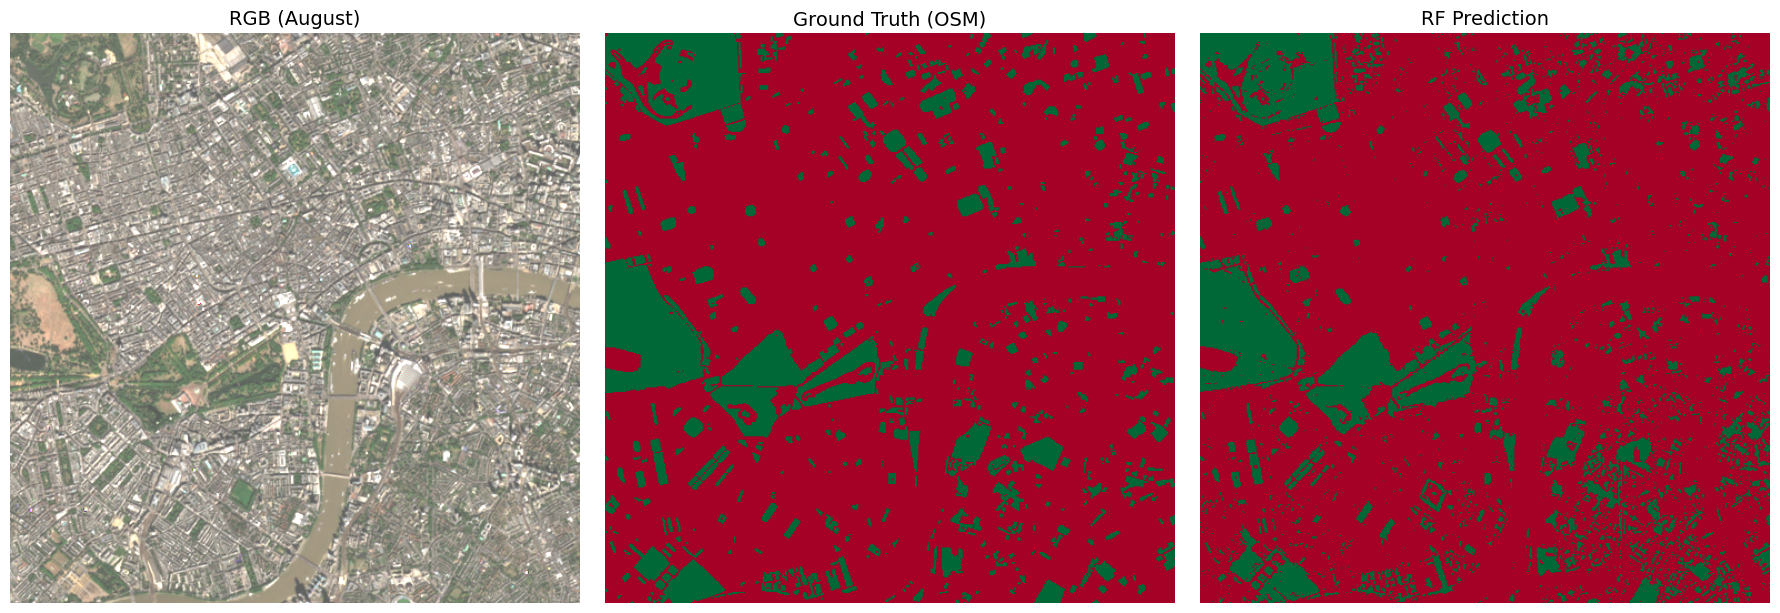

✓ Visualization saved


In [39]:
# Comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RGB
rgb = X[[6, 5, 4], :, :].transpose(1, 2, 0)
rgb_norm = np.clip(rgb / 3000, 0, 1)
axes[0].imshow(rgb_norm)
axes[0].set_title("RGB (August)", fontsize=14)
axes[0].axis('off')

# Ground truth
axes[1].imshow(y, cmap='RdYlGn', vmin=0, vmax=1)
axes[1].set_title("Ground Truth (OSM)", fontsize=14)
axes[1].axis('off')

# Prediction
axes[2].imshow(y_pred_map, cmap='RdYlGn', vmin=0, vmax=1)
axes[2].set_title("RF Prediction", fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.savefig(f"{run_folder}/comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved")

## 6. Three-Method Comparison: RF vs WorldCover vs Green Filter

Compare Random Forest, ESA WorldCover, and NDVI-based Green Filter classifications.

In [40]:
# WorldCover file paths by city
worldcover_paths = {
    "London": "ESA_WORLDCOVER_10M_2021_V200/MAP/ESA_WorldCover_10m_2021_v200_N51W003_Map/ESA_WorldCover_10m_2021_v200_N51W003_Map.tif",
    "Melbourne": "ESA_WorldCover_10m_2021_v200_S39E144_Map/ESA_WorldCover_10m_2021_v200_S39E144_Map.tif",
    # Add other cities as needed
}

if CITY not in worldcover_paths:
    print(f"WorldCover data not available for {CITY}")
else:
    print(f"Loading WorldCover for {CITY}...")

Loading WorldCover for London...


In [41]:
if CITY in worldcover_paths:
    # Load WorldCover and reproject to match our cropped Sentinel-2 data
    from rasterio.warp import reproject, Resampling
    
    # Read WorldCover data and metadata
    with rasterio.open(worldcover_paths[CITY]) as src:
        wc_data = src.read(1)
        wc_transform = src.transform
        wc_crs = src.crs
    
    # Create an empty array with our target shape
    worldcover = np.empty((h, w), dtype=np.uint8)
    
    # Reproject WorldCover to match our cropped data
    reproject(
        source=wc_data,
        destination=worldcover,
        src_transform=wc_transform,
        src_crs=wc_crs,
        dst_transform=stack_transform,  # Use renamed variable
        dst_crs=crs,
        resampling=Resampling.nearest  # Use nearest neighbor to preserve class values
    )
    
    # WorldCover green classes: 10=Tree, 20=Shrubland, 30=Grassland, 40=Cropland
    green_classes = [10, 20, 30, 40]
    worldcover_green = np.isin(worldcover, green_classes).astype(np.uint8)
    
    print(f"WorldCover shape: {worldcover.shape}")
    print(f"WorldCover green coverage: {100*worldcover_green.sum()/worldcover_green.size:.2f}%")

WorldCover shape: (513, 513)
WorldCover green coverage: 21.04%


In [42]:
if CITY in worldcover_paths:
    # Calculate NDVI for Green Filter
    def calculate_ndvi(nir, red):
        nir = nir.astype(float)
        red = red.astype(float)
        return (nir - red) / (nir + red + 1e-8)
    
    # Multi-temporal NDVI (average across 3 months)
    ndvi_april = calculate_ndvi(X[3], X[2])      # B08, B04 for April
    ndvi_august = calculate_ndvi(X[7], X[6])     # B08, B04 for August
    ndvi_november = calculate_ndvi(X[11], X[10]) # B08, B04 for November
    
    ndvi_mean = np.nanmean(np.stack([ndvi_april, ndvi_august, ndvi_november]), axis=0)
    
    # Lower threshold to match WorldCover better
    # 0.2 is a common threshold for vegetation (was 0.4)
    NDVI_THRESHOLD = 0.2
    green_filter_map = (ndvi_mean > NDVI_THRESHOLD).astype(np.uint8)
    
    print(f"Green Filter shape: {green_filter_map.shape}")
    print(f"Green Filter NDVI threshold: {NDVI_THRESHOLD}")
    print(f"Green Filter coverage: {100*green_filter_map.sum()/green_filter_map.size:.2f}%")
    print(f"NDVI range: {np.nanmin(ndvi_mean):.3f} to {np.nanmax(ndvi_mean):.3f}")

Green Filter shape: (513, 513)
Green Filter NDVI threshold: 0.2
Green Filter coverage: 23.25%
NDVI range: -0.200 to 0.599


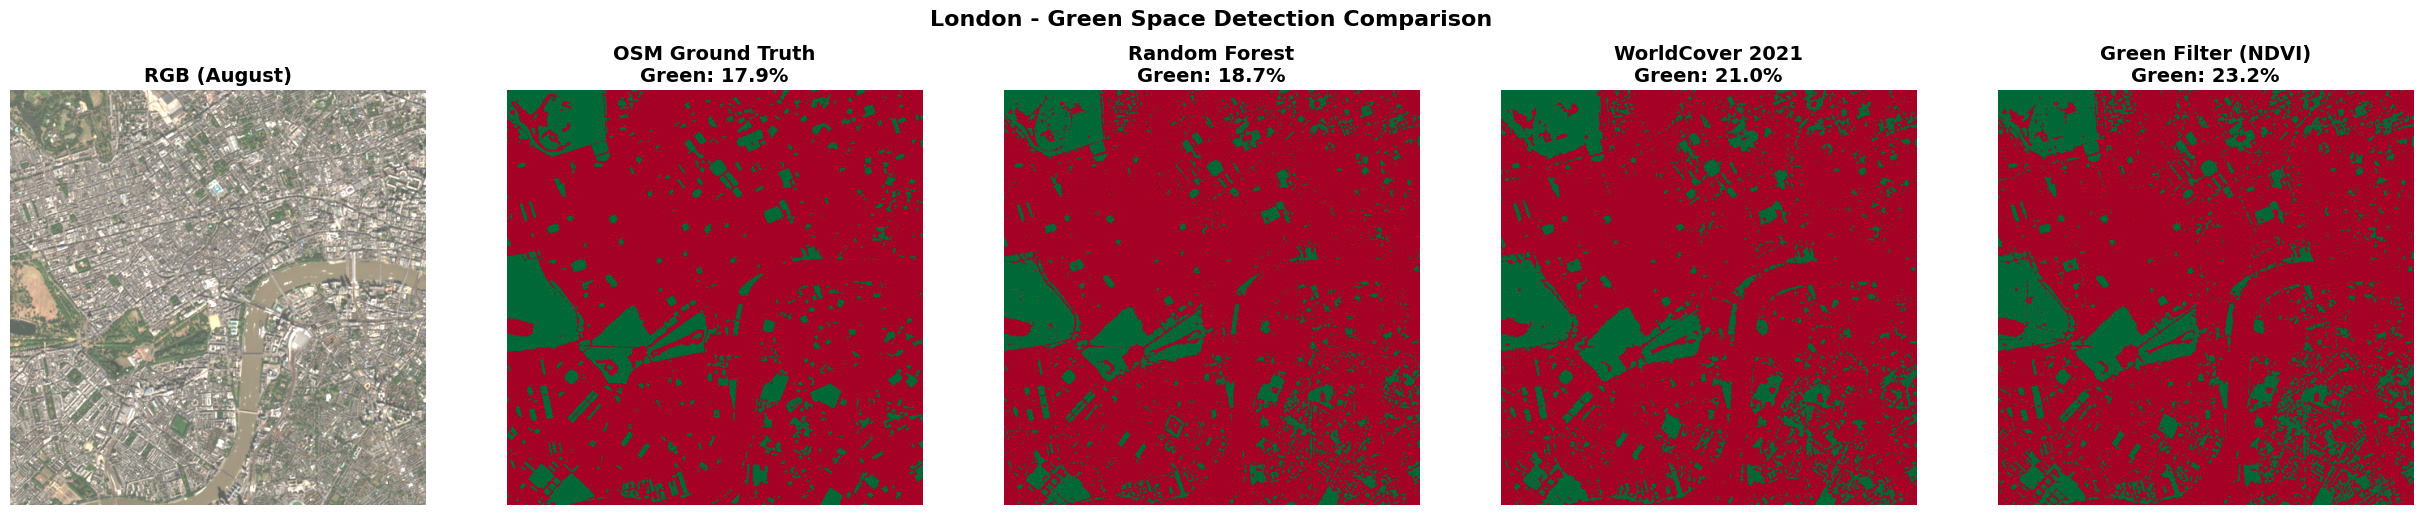

✓ Five-method comparison visualization saved


In [43]:
if CITY in worldcover_paths:
    # Create comprehensive comparison visualization
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    
    # 1. RGB composite (August)
    rgb = X[[6, 5, 4], :, :].transpose(1, 2, 0)
    rgb_norm = np.clip(rgb / 3000, 0, 1)
    axes[0].imshow(rgb_norm)
    axes[0].set_title("RGB (August)", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # 2. OSM Ground Truth
    axes[1].imshow(y, cmap='RdYlGn', vmin=0, vmax=1)
    axes[1].set_title(f"OSM Ground Truth\nGreen: {100*y.sum()/y.size:.1f}%", 
                      fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # 3. Random Forest
    axes[2].imshow(y_pred_map, cmap='RdYlGn', vmin=0, vmax=1)
    axes[2].set_title(f"Random Forest\nGreen: {100*y_pred_map.sum()/y_pred_map.size:.1f}%", 
                      fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    # 4. WorldCover
    axes[3].imshow(worldcover_green, cmap='RdYlGn', vmin=0, vmax=1)
    axes[3].set_title(f"WorldCover 2021\nGreen: {100*worldcover_green.sum()/worldcover_green.size:.1f}%", 
                      fontsize=14, fontweight='bold')
    axes[3].axis('off')
    
    # 5. Green Filter
    axes[4].imshow(green_filter_map, cmap='RdYlGn', vmin=0, vmax=1)
    axes[4].set_title(f"Green Filter (NDVI)\nGreen: {100*green_filter_map.sum()/green_filter_map.size:.1f}%", 
                      fontsize=14, fontweight='bold')
    axes[4].axis('off')
    
    plt.suptitle(f'{CITY} - Green Space Detection Comparison', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f"{run_folder}/five_method_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Five-method comparison visualization saved")

In [ ]:
if CITY in worldcover_paths:
    # Calculate agreement statistics
    total_pixels = y_pred_map.size
    
    # Pairwise agreement (all combinations)
    rf_wc_agree = np.sum(y_pred_map == worldcover_green) / total_pixels * 100
    rf_gf_agree = np.sum(y_pred_map == green_filter_map) / total_pixels * 100
    rf_osm_agree = np.sum(y_pred_map == y) / total_pixels * 100
    wc_gf_agree = np.sum(worldcover_green == green_filter_map) / total_pixels * 100
    wc_osm_agree = np.sum(worldcover_green == y) / total_pixels * 100
    gf_osm_agree = np.sum(green_filter_map == y) / total_pixels * 100
    
    # Four-way agreement (all methods)
    all_agree_green = np.sum((y_pred_map == 1) & (worldcover_green == 1) & (green_filter_map == 1) & (y == 1))
    all_agree_nongreen = np.sum((y_pred_map == 0) & (worldcover_green == 0) & (green_filter_map == 0) & (y == 0))
    all_agree = (all_agree_green + all_agree_nongreen) / total_pixels * 100
    
    # Three-way agreement (automated methods only: RF, WC, GF)
    three_agree_green = np.sum((y_pred_map == 1) & (worldcover_green == 1) & (green_filter_map == 1))
    three_agree_nongreen = np.sum((y_pred_map == 0) & (worldcover_green == 0) & (green_filter_map == 0))
    three_agree = (three_agree_green + three_agree_nongreen) / total_pixels * 100
    
    print("\n" + "="*70)
    print("AGREEMENT STATISTICS")
    print("="*70)
    print("\nGreen Coverage by Method:")
    print(f"  Random Forest:    {100*y_pred_map.sum()/total_pixels:.2f}%")
    print(f"  WorldCover 2021:  {100*worldcover_green.sum()/total_pixels:.2f}%")
    print(f"  Green Filter:     {100*green_filter_map.sum()/total_pixels:.2f}%")
    print(f"  OSM Ground Truth: {100*y.sum()/total_pixels:.2f}%")
    print("\nPairwise Agreement:")
    print(f"  Random Forest ↔ WorldCover:    {rf_wc_agree:.1f}%")
    print(f"  Random Forest ↔ Green Filter:  {rf_gf_agree:.1f}%")
    print(f"  Random Forest ↔ OSM:           {rf_osm_agree:.1f}%")
    print(f"  WorldCover ↔ Green Filter:     {wc_gf_agree:.1f}%")
    print(f"  WorldCover ↔ OSM:              {wc_osm_agree:.1f}%")
    print(f"  Green Filter ↔ OSM:            {gf_osm_agree:.1f}%")
    print(f"\nAutomated Methods Agreement (RF+WC+GF):  {three_agree:.1f}%")
    print(f"  - Agree on green:                      {three_agree_green:,} pixels")
    print(f"  - Agree on non-green:                  {three_agree_nongreen:,} pixels")
    print(f"\nAll 4 Methods Agreement (RF+WC+GF+OSM): {all_agree:.1f}%")
    print(f"  - Agree on green:                      {all_agree_green:,} pixels")
    print(f"  - Agree on non-green:                  {all_agree_nongreen:,} pixels")
    print("="*70)


AGREEMENT STATISTICS

Green Coverage by Method:
  Random Forest:    18.67%
  WorldCover 2021:  21.04%
  Green Filter:     23.25%
  OSM Ground Truth: 17.87%

Pairwise Agreement:
  Random Forest ↔ WorldCover:    92.5%
  Random Forest ↔ Green Filter:  94.1%
  Random Forest ↔ OSM:           92.1%
  WorldCover ↔ Green Filter:     92.6%
  WorldCover ↔ OSM:              89.4%
  Green Filter ↔ OSM:            88.6%

Automated Methods Agreement (RF+WC+GF):  89.6%
  - Agree on green:                      41,811 pixels
  - Agree on non-green:                  194,023 pixels

All 4 Methods Agreement (RF+WC+GF+OSM): 84.6%
  - Agree on green:                      34,197 pixels
  - Agree on non-green:                  188,352 pixels
